In [1]:
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
pd.options.display.max_columns = None
pd.options.display.max_colwidth = 200
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
from postgisgeocoder.db import get_engine_from_secrets, execute_result_returning_query
from postgisgeocoder.geocoding import geocode_addresses
from postgisgeocoder.utils import decode_geom_valued_column_to_geometry_type

# Workflow Demonstration

### Test dataset retrieval and preprocessing

This [dataset](https://data.cityofnewyork.us/dataset/NYC-Citywide-Rolling-Calendar-Sales/usep-8jbt) contains records for all (most? some?) property sales in NYC over the trailing 12 months.

In [4]:
nyc_property_sales_df = pd.read_csv(
    "https://data.cityofnewyork.us/api/views/usep-8jbt/rows.csv?accessType=DOWNLOAD"
)
nyc_property_sales_df["ZIP CODE"] = nyc_property_sales_df["ZIP CODE"].astype("Int64")
nyc_property_sales_df["full_address"] = (
    nyc_property_sales_df["ADDRESS"] +
    ", New York City, New York, " + 
    nyc_property_sales_df["ZIP CODE"].astype(str)
)
address_df = nyc_property_sales_df[["full_address"]].copy()
address_df = address_df.drop_duplicates(ignore_index=True)

In [5]:
print(nyc_property_sales_df.shape)
nyc_property_sales_df.head(2)

(97202, 22)


,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,full_address
0,1,ALPHABET CITY,02 TWO FAMILY DWELLINGS,1,377,70,NaN,B1,235 EAST 7TH STREET,NaN,10009,2.0,0.0,2.0,882,2160.0,2003.0,1,B1,"3,025,000",12/16/2021,"235 EAST 7TH STREET, New York City, New York, 10009"
1,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,376,54,NaN,C4,"719 EAST SIXTH STREET, 5C",NaN,10009,20.0,0.0,20.0,"2,302",9750.0,1900.0,2,C4,"154,196",06/11/2021,"719 EAST SIXTH STREET, 5C, New York City, New York, 10009"


### Connecting to postgis_geocoder database and geocoding addresses

In [6]:
engine = get_engine_from_secrets(use_sqlalchemy_v2=False, echo=False)
nyc_property_sales_gdf = geocode_addresses(
    df=nyc_property_sales_df, 
    engine=engine,
    full_address_colname="full_address", 
    verbose=True
)

100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 35.87it/s]
0it [00:00, ?it/s]
/home/matt/miniconda3/envs/geo_env/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


Total rows in original DataFrame:    97202
Rows with a geocoding result:        33475 (34.44% of total)


In [7]:
print(nyc_property_sales_gdf.shape)
nyc_property_sales_gdf.head(2)

(97202, 25)


,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,full_address,longitude,latitude,geometry
0,1,ALPHABET CITY,02 TWO FAMILY DWELLINGS,1,377,70,NaN,B1,235 EAST 7TH STREET,NaN,10009,2.0,0.0,2.0,882,2160.0,2003.0,1,B1,"3,025,000",12/16/2021,"235 EAST 7TH STREET, New York City, New York, 10009",NaN,NaN,None
1,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,376,54,NaN,C4,"719 EAST SIXTH STREET, 5C",NaN,10009,20.0,0.0,20.0,"2,302",9750.0,1900.0,2,C4,"154,196",06/11/2021,"719 EAST SIXTH STREET, 5C, New York City, New York, 10009",-73.978785,40.723399,POINT (-73.97878 40.72340)


### Evaluating the quality of 'successful' geocoding results

In [8]:
nyc_borough_boundaries = gpd.read_file(
    "https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=GeoJSON"
)
display(nyc_borough_boundaries)
print(
    f"nyc_borough_boundaries.crs as downloaded from source: {nyc_borough_boundaries.crs}"
)

nyc_borough_boundaries = nyc_borough_boundaries.to_crs(nyc_property_sales_gdf.crs)

print(
    f"nyc_borough_boundaries.crs after transforming it to match " + 
    f"nyc_property_sales_gdf: {nyc_borough_boundaries.crs}"
)

,boro_code,boro_name,shape_area,shape_leng,geometry
0,4,Queens,3040205594.95,900269.280485,"MULTIPOLYGON (((-73.82645 40.59053, -73.82642 40.59049, -73.82641 40.59046, -73.82640 40.59042, -73.82640 40.59039, -73.82641 40.59035, -73.82643 40.59032, -73.82646 40.59028, -73.82649 40.59026, ..."
1,3,Brooklyn,1934167333.21,728477.954082,"MULTIPOLYGON (((-73.86327 40.58388, -73.86381 40.58360, -73.86449 40.58361, -73.86504 40.58330, -73.86558 40.58303, -73.86638 40.58254, -73.86700 40.58198, -73.86773 40.58166, -73.86895 40.58171, ..."
2,5,Staten Island,1623631283.36,325924.002076,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 40.56642, -74.05030 40.56642, -74.05013 40.56641, -74.04998 40.56640, -74.04932 40.56589, -74.04924 40.56536, -74.05003 40.56532, -74.05074 40.56589, ..."
3,1,Manhattan,636620785.519,359993.126318,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 40.68389, -74.01218 40.68410, -74.01012 40.68534, -74.00879 40.68615, -74.00870 40.68619, -74.00860 40.68625, -74.00835 40.68640, -74.00816 40.68617, ..."
4,2,Bronx,1187193588.79,463868.599917,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 40.79564, -73.89724 40.79572, -73.89797 40.79564, -73.89857 40.79607, -73.89895 40.79623, -73.89919 40.79650, -73.89852 40.79694, -73.89788 40.79712, ..."


nyc_borough_boundaries.crs as downloaded from source: epsg:4326
nyc_borough_boundaries.crs after transforming it to match nyc_property_sales_gdf: epsg:4269


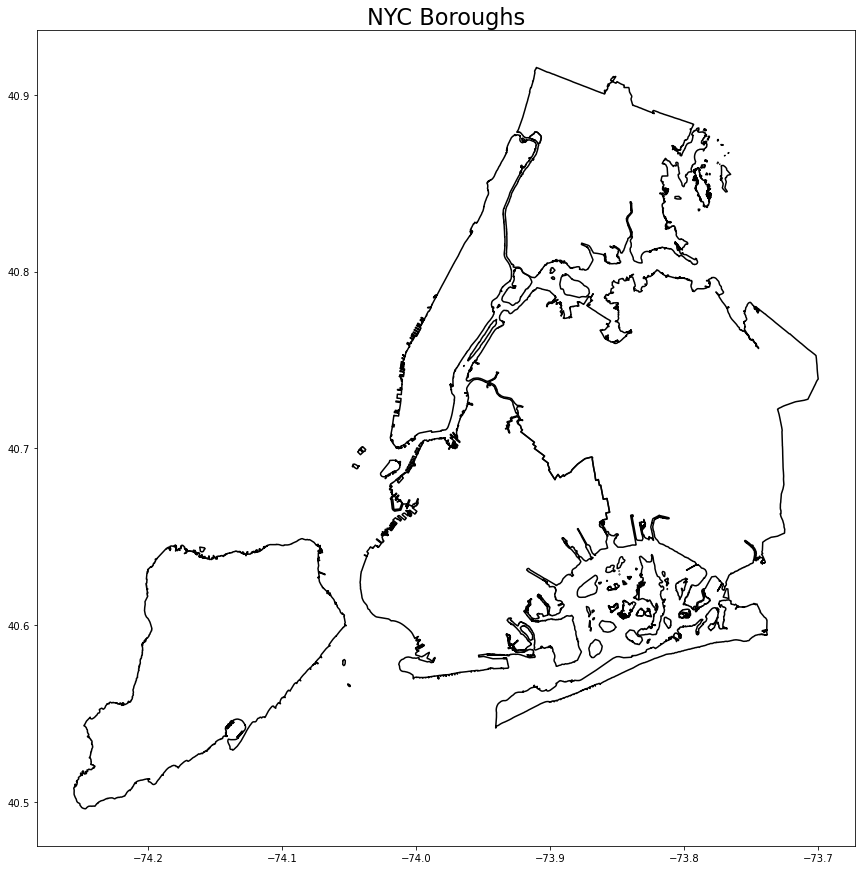

In [9]:
fig_width = 15
fig, ax = plt.subplots(figsize=(fig_width, fig_width))

ax = nyc_borough_boundaries.plot(color="none", edgecolor="black", linewidth=1.5, ax=ax)
_ = ax.set_title("NYC Boroughs", fontsize=fig_width*1.5)

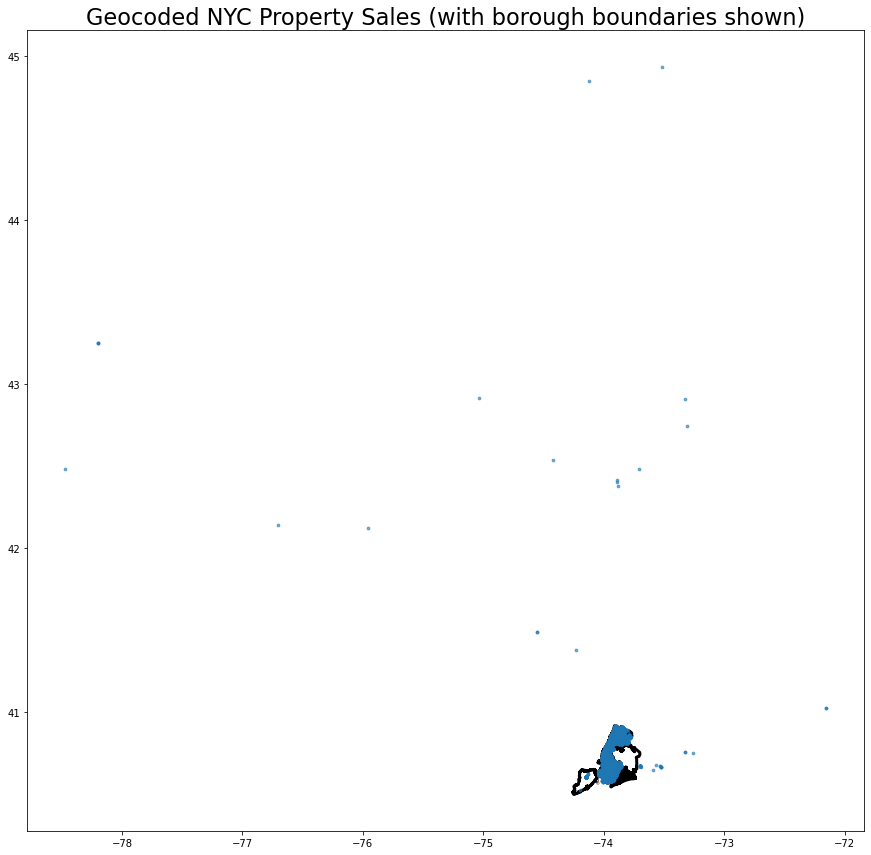

In [10]:
fig_width = 15
fig, ax = plt.subplots(figsize=(fig_width, fig_width))

base = nyc_borough_boundaries.plot(color="none", edgecolor="black", linewidth=3, ax=ax)
nyc_property_sales_gdf.plot(markersize=fig_width*0.5, alpha=0.6, ax=ax)
_ = ax.set_title("Geocoded NYC Property Sales (with borough boundaries shown)", fontsize=fig_width*1.5)

Ok, it looks like most of the addresses geocoded to New York City (as we'd expect), but some have geocoded to locations outside of NYC. Let's map them out again, but this time we'll include New York State. Conveniently, that shapefile is already included in the postgis_geocoder.

In [11]:
ny_state = execute_result_returning_query(
    query=f"""
        SELECT * 
        FROM tiger_data.state_all
        WHERE stusps = 'NY';
    """,
    engine=engine,
)
ny_state["geometry"] = decode_geom_valued_column_to_geometry_type(series=ny_state["the_geom"])
ny_state_gdf = gpd.GeoDataFrame(ny_state, crs=nyc_property_sales_gdf.crs)

/home/matt/miniconda3/envs/geo_env/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1981: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values


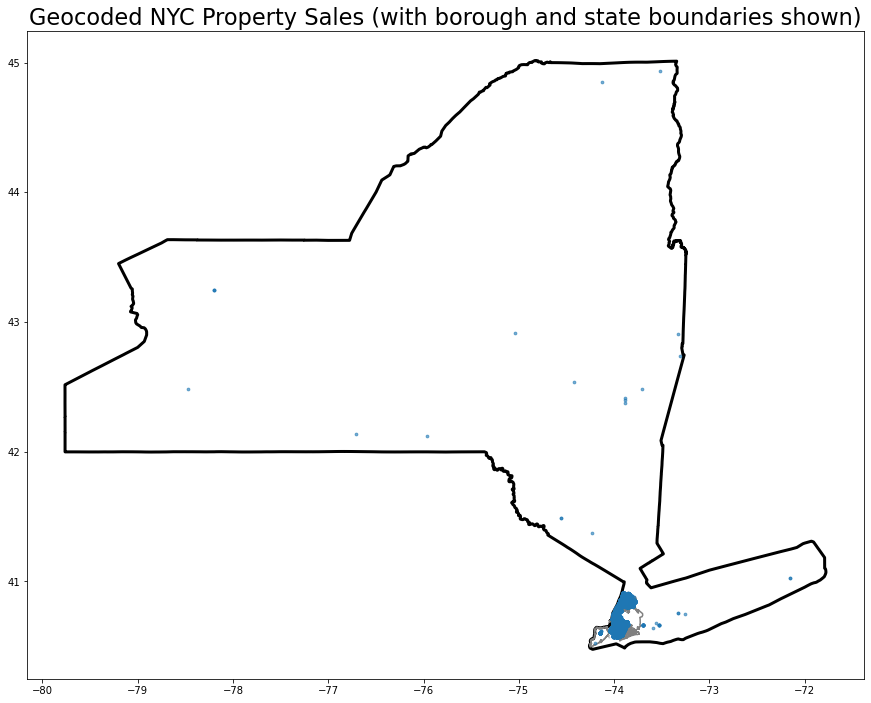

In [12]:
fig_width = 15
fig, ax = plt.subplots(figsize=(fig_width, fig_width))

base = ny_state_gdf.plot(color="none", edgecolor="black", linewidth=3, ax=ax)
ax = nyc_borough_boundaries.plot(color="none", edgecolor="grey", linewidth=1.5, ax=base)
ax = nyc_property_sales_gdf.plot(markersize=fig_width*0.5, alpha=0.6, ax=ax)
_ = ax.set_title("Geocoded NYC Property Sales (with borough and state boundaries shown)", fontsize=fig_width*1.5)

Ok, so it looks like all of the addresses that geocoded geocoded to locations within NY state. Let's see how many bad geocodings we have.

In [13]:
nyc_boundary_convex_hull = nyc_borough_boundaries.geometry.unary_union.convex_hull

In [14]:
outside_nyc_property_sales_gdf = nyc_property_sales_gdf.loc[
    ~(nyc_property_sales_gdf["geometry"].within(nyc_boundary_convex_hull)) & 
    (nyc_property_sales_gdf["geometry"].notnull())
].copy()

In [15]:
count_outside_nyc = outside_nyc_property_sales_gdf.shape[0]
total_geocoded_rows = nyc_property_sales_gdf["geometry"].notnull().sum()
print(f"Number of NYC property sales geocoded to locations outside of NYC (ie definately wrong): {count_outside_nyc:>7}")
print(f"Total number of geocoded property sales:                                                 " + 
      f"{total_geocoded_rows:>7} ({(100 * count_outside_nyc / total_geocoded_rows).round(2)}%)")

Number of NYC property sales geocoded to locations outside of NYC (ie definately wrong):      47
Total number of geocoded property sales:                                                   33475 (0.14%)


In [16]:
outside_nyc_property_sales_gdf

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,full_address,longitude,latitude,geometry
1764,1,CLINTON,09 COOPS - WALKUP APARTMENTS,2C,1060,160,NaN,C6,"464 WEST 51ST, 5W",NaN,10019,NaN,NaN,NaN,NaN,NaN,1901.0,2,C6,"330,000",06/24/2021,"464 WEST 51ST, 5W, New York City, New York, 10019",-73.884570,42.376029,POINT (-73.88457 42.37603)
5376,1,GREENWICH VILLAGE-WEST,09 COOPS - WALKUP APARTMENTS,2,638,19,NaN,C6,"142 BANK ST, 3B",NaN,10019,NaN,NaN,NaN,NaN,NaN,1939.0,2,C6,"930,000",08/10/2021,"142 BANK ST, 3B, New York City, New York, 10019",-78.195699,43.247805,POINT (-78.19570 43.24781)
5377,1,GREENWICH VILLAGE-WEST,09 COOPS - WALKUP APARTMENTS,2,638,19,NaN,C6,"142 BANK STREET, 2A",NaN,10019,NaN,NaN,NaN,NaN,NaN,1939.0,2,C6,"840,000",10/22/2021,"142 BANK STREET, 2A, New York City, New York, 10019",-78.195699,43.247805,POINT (-78.19570 43.24781)
5379,1,GREENWICH VILLAGE-WEST,09 COOPS - WALKUP APARTMENTS,2,638,19,NaN,C6,"156 BANK STREET, 2A",NaN,10019,NaN,NaN,NaN,NaN,NaN,1939.0,2,C6,"1,250,000",02/02/2022,"156 BANK STREET, 2A, New York City, New York, 10019",-78.195907,43.247812,POINT (-78.19591 43.24781)
6427,1,HARLEM-CENTRAL,13 CONDOS - ELEVATOR APARTMENTS,2,1746,1142,NaN,R4,"1485 5, 24A",24A,10035,1.0,NaN,1.0,NaN,NaN,2007.0,2,R4,0,11/10/2021,"1485 5, 24A, New York City, New York, 10035",-74.123299,44.849376,POINT (-74.12330 44.84938)
13500,1,TRIBECA,10 COOPS - ELEVATOR APARTMENTS,2,140,1,NaN,D4,"1 HUDSON STREET, 8",NaN,10007,NaN,NaN,NaN,NaN,NaN,1915.0,2,D4,"3,450,000",06/29/2021,"1 HUDSON STREET, 8, New York City, New York, 10007",-75.960641,42.119641,POINT (-75.96064 42.11964)
14534,1,UPPER EAST SIDE (59-79),10 COOPS - ELEVATOR APARTMENTS,2,1395,50,NaN,D4,"150 EAST 61, 2A",NaN,10065,NaN,NaN,NaN,NaN,NaN,1960.0,2,D4,"560,000",05/05/2021,"150 EAST 61, 2A, New York City, New York, 10065",-74.557162,41.488170,POINT (-74.55716 41.48817)
14552,1,UPPER EAST SIDE (59-79),10 COOPS - ELEVATOR APARTMENTS,2,1396,33,NaN,D4,"167 EAST 61, 26B",NaN,10065,NaN,NaN,NaN,NaN,NaN,1983.0,2,D4,0,12/15/2021,"167 EAST 61, 26B, New York City, New York, 10065",-74.557198,41.487877,POINT (-74.55720 41.48788)
17587,1,UPPER EAST SIDE (79-96),10 COOPS - ELEVATOR APARTMENTS,2,1571,8,NaN,D4,"407 EAST 91, 2A",NaN,10128,NaN,NaN,NaN,NaN,NaN,1901.0,2,D4,"835,000",09/09/2021,"407 EAST 91, 2A, New York City, New York, 10128",-73.310521,42.740380,POINT (-73.31052 42.74038)
22223,1,UPPER WEST SIDE (96-116),09 COOPS - WALKUP APARTMENTS,2C,1889,33,NaN,C6,"332 WEST 101ST, 4F",NaN,10025,NaN,NaN,NaN,NaN,NaN,1925.0,2,C6,"546,000",03/15/2021,"332 WEST 101ST, 4F, New York City, New York, 10025",-73.329361,42.908164,POINT (-73.32936 42.90816)
